<a href="https://colab.research.google.com/github/maciaslab/fitFP/blob/main/fittingpolfluor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polaritzation Fluorescence Fittings
##Instructions
1. Fill "Concentracions" with the protein concentrations (nM/uM), separated by spaces. Choose the corresponding unit
2. Fill "Anisotropies" with the corresponding anisotropies.
3. Fill "ConcLig" with the ligand concentration.
4. Push play


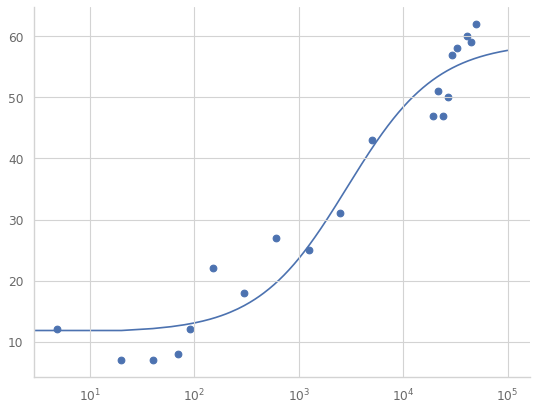

##KD: 2847.8566 ± 18.6654 uM ; R2 = 0.9531

Method: Without genetic parameters.

In [1]:

import warnings
warnings.filterwarnings('ignore')


#@markdown ### Protein concentration in nanoMolar / microMolar:
Concentrations = "50 45 40.5 32.8 29.5 26.6 23.9 21.5 19.4 5 2.5 1.25 0.6 0.3 0.15 0.07 0.04 0.02 0.09 0.0048 0" #@param {type:"string"}
unit = "micro" #@param ["micro", "nano"]
#@markdown ---

#Cas 1. Proteina + Lligand fluorescent, no competició
#<-----
#Premer play

#
#Concentracions=" 2.229299363	1.940681729	1.843699287	1.746324638	1.648555397	1.550389162	1.451823508	1.352855994	1.253484157	1.153705514	1.053517562	0.952917777	0.851903614	0.750472508	0.648621873	0.546349099	0.443651558	0.340526596	0.	"
#Anisotropies=""

#Concentracions="10 5 2.5 1.25 1 0.71 0.51 0.36 0.26 0.18 0.13 0.095 0.07 0.048 0.034 0.024 "
#@markdown ### Anisotropies:
Anisotropies="62 59 60 58 57 50 47 51 47 43 31 25 27 18 22 8 7 7 12 12 13" #@param {type:"string"}
#@markdown ---
#@markdown ### Ligand concentration in nanoMolar:
ConcLig = 100 #@param {type:"number"}



#ConcLig=0.100 #nM



import numpy as np

ConcProt=np.array(Concentrations.split()).astype(np.float)
if unit=="micro":
  ConcProt=ConcProt*1000
Aniso=np.array(Anisotropies.split()).astype(np.float)
Ab_=np.max(Aniso)
Af_=np.min(Aniso)


from pandas import read_csv
from scipy.optimize import curve_fit, differential_evolution
from matplotlib import pyplot
import warnings
import math
import seaborn as sns
from IPython.display import display, Markdown, Latex


from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

sns.set(
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})



def fit_KD1(x,Kd,Ab,Af):
    cl=ConcLig
    #Ab=150
    #Af=Af_
    A=[]
    #print(x)
    for item in x:
        Q=1
        #print(item)
        d=Kd+cl+item
        #print(d)
        s=(d*d) - (4*cl*item)
        #if (s<0):
        #    s=0
        #print(s)
        fsb=(d - math.sqrt( s) )/ (2*cl)
        a=((Q*(fsb*Ab)) + ((1-fsb)* Af)) / (1- ((1-Q)*fsb ) )
        A.append(a)
    return A

def sumOfSquaredError(parameterTuple,func,xdata,ydata):

    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    #print(parameterTuple,func,xdata,ydata)

    val = func(xdata, *parameterTuple)

    return np.sum( np.subtract(np.array(ydata), np.array(val)) ** 2.0)

def generate_Initial_Parameters(func,xdata,ydata):

    #finds best starting parameters to fit xdata and ydata to func.
    minY = np.min(xdata)
    maxY = np.max(xdata)
    minX = np.min(ydata)
    maxX = np.max(ydata)

    parameterBounds = []
    parameterBounds.append([minX/10, maxX*10]) # search bounds for kd
    parameterBounds.append([maxY/1.1, maxY*1.1]) # search bounds for Ab
    parameterBounds.append([minY/1.1, minY*1.1]) # search bounds for Af

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, args=([func,xdata,ydata]),seed=3)
    return result.x

func=fit_KD1



#Without genetic parameters

fp,cov=curve_fit(func, ConcProt, Aniso, p0=[np.max(ConcProt),np.max(Aniso),np.min(Aniso)],bounds=( [0, min(np.max(Aniso)*0.7,np.max(Aniso)*1.8) ,min(np.min(Aniso)*0.7,np.min(Aniso)*1.8)],[np.inf, max(np.max(Aniso)*0.7,np.max(Aniso)*1.4), max(np.min(Aniso)*0.7,np.min(Aniso)*1.8)]),maxfev=100000)
modelPredictions = func(ConcProt, *fp)
absError = np.subtract(np.array(modelPredictions),np.array(Aniso))
SE = np.square(absError)
MSE = np.mean(SE)
RMSE = np.sqrt(MSE)
Rsquared = 1.0 - (np.var(absError) / np.var(Aniso))
#print(fp,Rsquared)

#With genetic parameters

geneticParameters = generate_Initial_Parameters(fit_KD1,ConcProt,Aniso)
#print(geneticParameters)
genetipParameters=[geneticParameters[0], geneticParameters[1],np.min(Aniso)]
geneticParameters=[np.max(ConcProt),np.max(Aniso),np.min(Aniso)]
fittedParameters, pcov = curve_fit(func,ConcProt,Aniso, p0=geneticParameters,bounds=( [0, min(np.max(Aniso)*0.7,np.max(Aniso)*1.8) ,min(np.min(Aniso)*0.7,np.min(Aniso)*1.8)],[np.inf, max(np.max(Aniso)*0.7,np.max(Aniso)*1.4), max(np.min(Aniso)*0.7,np.min(Aniso)*1.8)]),maxfev=100000)
modelPredictions = func(ConcProt, *fittedParameters)
absError = np.subtract(np.array(modelPredictions),np.array(Aniso))
SE = np.square(absError)
MSE = np.mean(SE)
RMSE = np.sqrt(MSE)
Rsquared2 = 1.0 - (np.var(absError) / np.var(Aniso))
#print(fittedParameters,Rsquared2)


method="Method: Without genetic parameters."
#Choose best method

if Rsquared2>Rsquared:
    Rsquared=Rsquared2
    fp=fittedParameters
    method="Method: With genetic parameters."

pyplot.xscale('log')
pyplot.scatter(ConcProt,Aniso)
Kd,Ab,Af=fp


x_line = ConcProt
x_line=np.linspace(0,np.max(ConcProt)*2,num=5000)


y_line= (func(x_line,Kd,Ab,Af))
#y_line= (func(x_line,Kd,Ab,Af))
pyplot.plot(x_line,y_line)
pyplot.show()



#Calculate Std.error:
#https://people.duke.edu/~rnau/mathreg.htm#:~:text=Standard%20error%20of%20the%20regression%20%3D%20(SQRT(1%20minus%20adjusted,of%20the%20regression%20goes%20down.
stdevs_err=math.sqrt((1-Rsquared)*np.var(Aniso))
sterr_regr=stdevs_err*math.sqrt(len(Aniso)-1/len(Aniso)-2)

myunit="nM"

k="{:.4f}".format(fp[0])+ " ± "+ "{:.4f}".format(sterr_regr) +" nM "
if fp[0]> 1000:
    k="{:.4f}".format(fp[0])+ " ± "+ "{:.4f}".format(sterr_regr) +" uM "
    myunit="uM"



m1="KD: " + k+ "; R2 = " + "{:.4f}".format(Rsquared)



#k="{:.4f}".format(fp[0])+ " nM "
#if fp[0]> 1000:
#    k="{:.4f}".format(fp[0]/1000)+ " uM "
#m1="KD: " + k+"; R2 = " + "{:.4f}".format(Rsquared)
display(Markdown('##'+m1))
display(Markdown(method))